Lab 7

Student Name: Wenjing Dong, Student Number:91964156

In [10]:
from IPython.display import Image
import IPython.display as display
# import plotting package and numerical python package for use in examples later
import matplotlib.pyplot as plt
# make the plots happen inline
% matplotlib inline  
# import the numpy array handling library
import numpy as np
# import the quiz script

Problem 2(b)

Let $x=md$ and $t=p\, dt$ and consider a
solution 
$$\begin{aligned}
u &=& {\cal R}e \{ {\cal U} \exp [i(kx - \omega t)] \}\\
&=& {\cal R}e \{ {\cal U} \exp [i(kmd - \omega p\, dt)] \} \nonumber\end{aligned}$$
$$\begin{aligned}
h &=& {\cal R}e \{ {\cal H} \exp [i(kx  - \omega t) \}\\
&=& {\cal R}e \{ {\cal H} \exp [i(kmd - \omega p\, dt)] \} \nonumber\end{aligned}$$
Substitue u and h into equations of non-staggered grid. We will have the following algebra equations:
$$\left[
\begin{array}{cc} - \sin(\omega dt)/ dt &  g \sin(kd)/d \\
 H \sin(kd)/d &  -\sin(\omega \, dt)/ dt \\
\end{array}
\right]
\left[
\begin{array}{c} {\cal U}\\ {\cal H}\\ 
\end{array} \right]
= 0.$$ 
To have non-trivial solutions, the determint has to be zero, which gives this numerical dispersion relation:
$$ \frac{\sin^2(\omega \, dt)}{dt^2} = gH \frac {\sin^2(kd)}{d^2}$$
Following the steps in Lab 7 Stability, we will finally have this inequality:
$$1 > q^2 dt^2 =  \frac {gH}{d^2} \sin^2(kd/2) dt^2$$ for all $k$.
This gives CFL condition for dt:
$$dt < \frac {d}{\sqrt{gH}}$$

For 15 gird points and dx=1cm, according to the CFL condition, $ dt<0.032s $.

Using rain.py, when $dt=0.032s$, solutions are stable but when $dt=0.033s$, solutions are not stable. So the analytic analysis gives the same stablility condition as rain.py does.

Problem 4

Grid 2 gives better accucary for d=R/2 than grid 1.

For no variation in y, the first and second equations contain v and u. For gird 1, the the first equation as an example, when the derivate of u with respect to t is approximated using centered difference method, v has to be approximated by the two neighbor points' values. That is,
$$\frac{u(x,t+dt)-u(x,t-dt)}{2dt}-f\frac{v(x+dx/2,t)+v(x-dx/2,t)}{2}+g\frac{h(x+dx/2,t)-h(x-dx/2,t)}{dx}=0$$
However, for grid 2, $v$ does not need to be approximated by the two neighbor points' values. That is,
$$\frac{u(x,t+dt)-u(x,t-dt)}{2dt}-fv(x,t)+g\frac{h(x+dx/2,t)-h(x-dx/2,t)}{dx}=0$$
So grid 2 is more accurate than grid 1.

Problem 5

Discretized equations for grid 2 are:
$$\frac{u_i(t+dt)-u_i(t-dt)}{2dt}-fv_i(t)+g\frac{h_{i+1}(t)-h_i(t)}{dx}=0$$
$$\frac{v_i(t+dt)-v_i(t-dt)}{2dt}+fu_i(t)=0$$
$$\frac{h_i(t+dt)-h_i(t-dt)}{2dt}+H\frac{u_i(t)-u_{i-1}(t)}{dx}=0$$


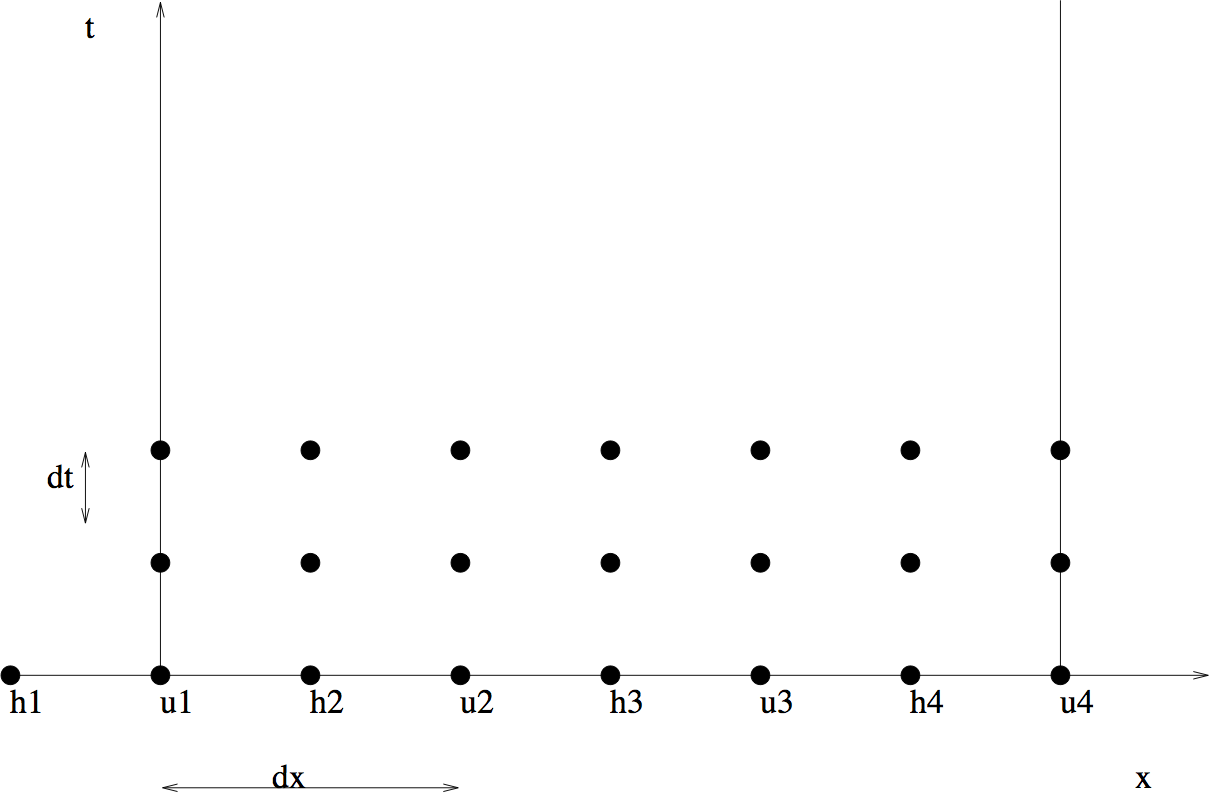

In [6]:
Image(filename='images/stagger.png',width='50%') 

Assume the boundary is at u1 and u4.

Boundary conditions:

$$u_1(t)=0$$
$$v_1(t)=0$$
$$v_1(t)=0$$
$$v_4(t)=0$$

Initial conditions:

When $t=0$,
$$h_3(0)=h_0$$
All other points have zero elevation. And all points have zero velocity.

When $t=dt$,
$$u_2(dt)=-gh_0\frac{dt}{dx}$$
$$u_3(dt)=gh_0\frac{dt}{dx}$$
$$v_2(dt)=fgh_0\frac{dt^2}{dx}$$
$$v_3(dt)=-fgh_0\frac{dt^2}{2dx}$$
$$h_2(dt)=gHh_0\frac{dt^2}{2dx^2}$$
$$h_3(dt)=h_0 - gHh_0\frac{dt^2}{dx^2}$$
$$h_4(dt)=gHh_0\frac{dt^2}{2dx^2}$$

In [11]:
#!/usr/bin/env python
"""Calculate the values of surface height (h), east-west velocity
(u), and north-south velocity(v), in a dish of water where a point disturbance of h initiates waves.
Use the simplified shallow water equations on a non-staggered grid.
"""
from __future__ import division
import copy
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.colorbar as colorbar
import os,glob

class Quantity(object):
    """Generic quantity to define the data structures and method that
    are used for both u and h.

    u, v, and h objects will be instances of this class.
    """
    def __init__(self, n_grid, n_time):
        """Initialize an object with prev, now, and next arrays of
        n_grid points, and a store array of n_time time steps.
        """
        self.n_grid = n_grid
        # Storage for values at previous, current, and next time step
        self.prev = np.empty(n_grid)
        self.now = np.empty(n_grid)
        self.next = np.empty(n_grid)
        # Storage for results at each time step.  In a bigger model
        # the time step results would be written to disk and read back
        # later for post-processing (such as plotting).
        self.store = np.empty((n_grid, n_time))


    def store_timestep(self, time_step, attr='next'):
        """Copy the values for the specified time step to the storage
        array.

        The `attr` argument is the name of the attribute array (prev,
        now, or next) that we are going to store.  Assigning the value
        'next' to it in the function def statement makes that the
        default, chosen because that is the most common use (in the
        time step loop).
        """
        # The __getattribute__ method let us access the attribute
        # using its name in string form;
        # i.e. x.__getattribute__('foo') is the same as x.foo, but the
        # former lets us change the name of the attribute to operate
        # on at runtime.
        self.store[:, time_step] = self.__getattribute__(attr)


    def shift(self):
        """Copy the .now values to .prev, and the .next values to .new.

        This reduces the storage requirements of the model to 3 n_grid
        long arrays for each quantity, which becomes important as the
        domain size and model complexity increase.  It is possible to
        reduce the storage required to 2 arrays per quantity.
        """
        # Note the use of the copy() method from the copy module in
        # the standard library here to get a copy of the array, not a
        # copy of the reference to it.  This is an important and
        # subtle aspect of the Python data model.
        self.prev = copy.copy(self.now)
        self.now = copy.copy(self.next)


def initial_conditions(u, v, h, ho):
    """Set the initial condition values.
    """
    u.prev[:] = 0
    v.prev[:] = 0
    h.prev[:] = 0
    h.prev[len(h.prev) // 2] = ho


def boundary_conditions(u_array, v_array, n_grid):
    """Set the boundary condition values.
       h is not on the boundary.
    """
    u_array[0] = 0
    u_array[n_grid - 1] = 0
    v_array[0] = 0
    v_array[n_grid - 1] = 0




def first_time_step(u, v, h, g, H, dt, dx, ho, gu, gh, n_grid, f):
    """Calculate the first time step values from the analytical
    predictor-corrector derived from equations 4.18 and 4.19.
    """
    u.now[1:n_grid - 1] = 0
    v.now[1:n_grid - 1] = 0
    factor = gu * ho 
    midpoint_h = len(h.prev)// 2
    u.now[midpoint_h] = -factor
    u.now[midpoint_h + 1] = factor
    v.now[midpoint_h] = f * dt * factor/2
    v.now[midpoint_h + 1] = -f * dt * factor/2
    h.now[0:n_grid - 1] = 0
    h.now[midpoint_h] = ho - g * H * ho * dt ** 2 / (dx ** 2)
    h.now[midpoint_h -1] = g * H *ho * dt**2 / (2 * dx**2)
    h.now[midpoint_h +1] = g * H *ho * dt**2 / (2 * dx**2)


def leap_frog(u, v, h, gu, gh, n_grid, f, dt):
    """Calculate the next time step values using the leap-frog scheme
    derived from equations 4.16 and 4.17.
    """
    for pt in np.arange(1, n_grid - 1):
        u.next[pt] = u.prev[pt] - 2 * gu * (h.now[pt] - h.now[pt - 1]) + 2 * f* v.now[pt] * dt
        v.next[pt] = v.prev[pt] - 2 * f * u.now[pt] * dt
    for pt in np.arange(0, n_grid-1):
        h.next[pt] = h.prev[pt] - 2 * gh * (u.now[pt+1] - u.now[pt])


def make_graph(u, v, h, dt, n_time, n_grid):
    """Create graphs of the model results using matplotlib.

    You probably need to run the rain script from within ipython,
    in order to see the graphs.  And
    the default run for 5 time steps doesn't produce much of interest;
    try at least 100 steps.
    """

    # Create a figure with 2 sub-plots
    fig, (ax_u, ax_v, ax_h) = plt.subplots(3,1, figsize=(10,10))
    
    # Set the figure title, and the axes labels.
    the_title = fig.text(0.25, 0.95, 'Results from t = %.3fs to %.3fs' % (0, dt*n_time))
    ax_u.set_ylabel('u [cm/s]')
    ax_v.set_ylabel('v[cm/s]')
    ax_h.set_ylabel('h [cm]')
    ax_h.set_xlabel('Grid Point')

    # We use color to differentiate lines at different times.  Set up the color map
    cmap = plt.get_cmap('spectral')
    cNorm  = colors.Normalize(vmin=0, vmax=1.*n_time)
    cNorm_inseconds = colors.Normalize(vmin=0, vmax=1.*n_time*dt)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

    # Only try to plot 20 lines, so choose an interval if more than that (i.e. plot
    # every interval lines
    interval = np.int(np.ceil(n_time/20))

    # Do the main plot
    velocityaxis = [x for x in range(n_grid)]
    haxis = [x+1/2 for x in range(n_grid-1)]
    for time in range(0, n_time, interval):
        colorVal = scalarMap.to_rgba(time)
        ax_u.plot(velocityaxis, u.store[:, time], color=colorVal)
        ax_v.plot(velocityaxis, v.store[:, time], color=colorVal)
        ax_h.plot(haxis, h.store[:, time], color=colorVal)
    ax_h.set_xlim([0,n_grid -1])

    # Add the custom colorbar
    ax2 = fig.add_axes([0.95, 0.05, 0.05, 0.9])
    cb1 = colorbar.ColorbarBase(ax2, cmap=cmap, norm=cNorm_inseconds)
    cb1.set_label('Time (s)')
    return

def rain(args):
    """Run the model.

    args is a 2-tuple; (number-of-time-steps, number-of-grid-points)
    """
    n_time = int(args[0])
    n_grid = int(args[1])
#     Alternate implementation:
#     n_time, n_grid = map(int, args)

    # Constants and parameters of the model
    g = 980                     # acceleration due to gravity [cm/s^2]
    H = 1                       # water depth [cm]
    dt = 0.001                  # time step [s]
    dx = 1                      # grid spacing [cm]
    ho = 0.01                   # initial perturbation of surface [cm]
    gu = g * dt / dx            # first handy constant
    gh = H * dt / dx            # second handy constant
    f = 0                       #
    # Create velocity and surface height objects
    u = Quantity(n_grid, n_time)
    v = Quantity(n_grid, n_time)
    h = Quantity(n_grid - 1, n_time)
    # Set up initial conditions and store them in the time step
    # results arrays
    initial_conditions(u, v, h, ho)
    u.store_timestep(0, 'prev')
    v.store_timestep(0, 'prev')
    h.store_timestep(0, 'prev')
    # Calculate the first time step values from the
    # predictor-corrector, apply the boundary conditions, and store
    # the values in the time step results arrays
    first_time_step(u, v, h, g, H, dt, dx, ho, gu, gh, n_grid, f)
    boundary_conditions(u.now, v.now, n_grid)
    u.store_timestep(1, 'now')
    v.store_timestep(1, 'now')
    h.store_timestep(1, 'now')
    # Time step loop using leap-frog scheme
    for t in np.arange(2, n_time):
        # Advance the solution and apply the boundary conditions
        leap_frog(u, v, h, gu, gh, n_grid, f, dt)
        boundary_conditions(u.next, v.next, n_grid)
        # Store the values in the time step results arrays, and shift
        # .now to .prev, and .next to .now in preparation for the next
        # time step
        u.store_timestep(t)
        v.store_timestep(t)
        h.store_timestep(t)
        u.shift()
        v.shift()
        h.shift()

    # Plot the results as colored graphs
    make_graph(u, v, h, dt, n_time, n_grid)
    return


if __name__ == '__main__':
    # sys.argv is the command-line arguments as a list. It includes
    # the script name as its 0th element. Check for the degenerate
    # cases of no additional arguments, or the 0th element containing
    # `sphinx-build`. The latter is a necessary hack to accommodate
    # the sphinx plot_directive extension that allows this module to
    # be run to include its graph in sphinx-generated docs.
    #
    #  the following command, executed in the plotfile directory makes a movie on ubuntu called
    #   outputmplt.avi
    #  which can be
    #  looped with mplayer -loop 0
    #
    #  mencoder mf://*.png -mf type=png:w=800:h=600:fps=25 -ovc lavc -lavcopts vcodec=mpeg4 -oac copy -o outputmplt.avi
    #
    if len(sys.argv) == 1 or 'sphinx-build' in sys.argv[0]:
        # Default to 50 time steps, and 9 grid points
        rain((50, 9))
    elif len(sys.argv) == 3:
        # Run with the number of time steps and grid point the user gave
        rain(sys.argv[1:])
    else:
        print ('Usage: rain n_time n_grid')
        print ('n_time = number of time steps; default = 5')
        print ('n_grid = number of grid points; default = 9')

Usage: rain n_time n_grid
n_time = number of time steps; default = 5
n_grid = number of grid points; default = 9


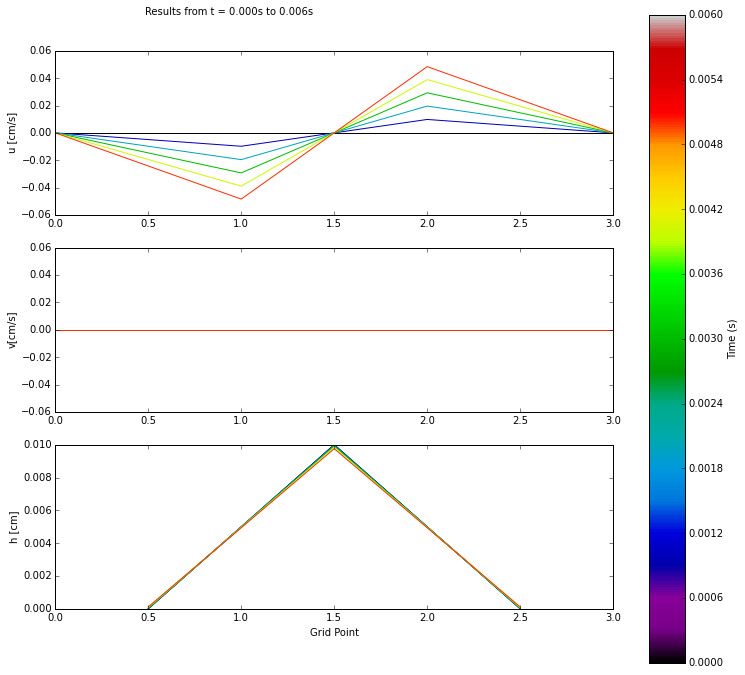

In [18]:
problem5.rain([6,4])